Precisión media en la validación cruzada: 0.9949579831932773
Precisión en el conjunto de prueba: 0.9915966386554622


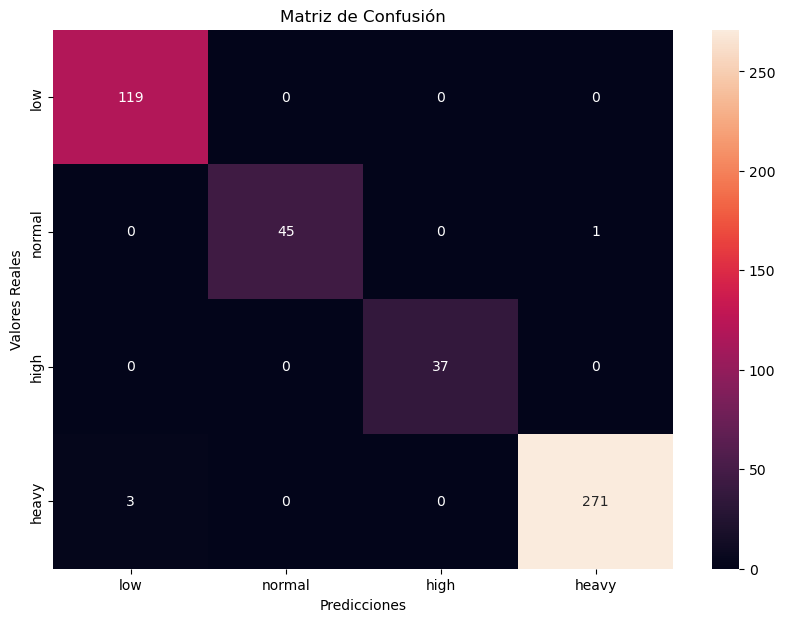

              precision    recall  f1-score   support

         low       0.98      1.00      0.99       119
      normal       1.00      0.98      0.99        46
        high       1.00      1.00      1.00        37
       heavy       1.00      0.99      0.99       274

    accuracy                           0.99       476
   macro avg       0.99      0.99      0.99       476
weighted avg       0.99      0.99      0.99       476



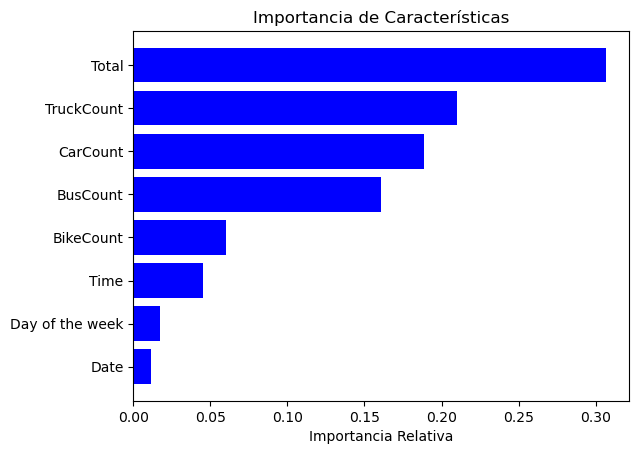

          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0   1:00:00 AM     4        Saturday        15          5         0   
1   8:30:00 PM     8       Wednesday        86         15        15   
2   9:45:00 PM     7         Tuesday       102          5        19   
3   6:45:00 AM    15          Sunday       109         14        38   
4  12:15:00 AM    29          Sunday        14          2         1   

   TruckCount  Total Predicted Traffic Situation  
0          10     30                         low  
1          23    139                        high  
2          11    137                      normal  
3           1    162                        high  
4          26     43                      normal  


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Función para convertir la columna de tiempo a horas del día
def convert_time_to_hour(data):
    return data['Time'].apply(lambda x: datetime.strptime(x, '%I:%M:%S %p').hour)

# Función para codificar variables categóricas
def encode_categorical(data, column):
    encoder = LabelEncoder()
    data[column] = encoder.fit_transform(data[column])
    return data, encoder

# Carga de los datos de entrenamiento
train_data_original = pd.read_csv('C:\\KOPURU\\DATOS\\train\\train_datos-trafico.csv')
train_data = train_data_original.copy()

# Preprocesamiento de los datos de entrenamiento
train_data['Time'] = convert_time_to_hour(train_data)
train_data, day_encoder = encode_categorical(train_data, 'Day of the week')

# Escalado de datos numéricos
scaler = StandardScaler()
numerical_columns = ['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])

# Separación de características y etiquetas
X = train_data.drop('Traffic Situation', axis=1)
y = train_data['Traffic Situation']

# Validación cruzada
modelo_rf = RandomForestClassifier(random_state=42)
scores = cross_val_score(modelo_rf, X, y, cv=5)
print("Precisión media en la validación cruzada:", scores.mean())

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo de bosque aleatorio
modelo_rf.fit(X_train, y_train)

# Evaluación del modelo en el conjunto de prueba
y_pred_test = modelo_rf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Precisión en el conjunto de prueba:", accuracy_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

# Crear un mapa para mapear valores numéricos a etiquetas originales
label_mapping = {0: 'low', 1: 'normal', 2: 'high', 3: 'heavy'}
labels = [label_mapping[i] for i in range(len(label_mapping))]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión')
plt.show()

# Informe de clasificación
report = classification_report(y_test, y_pred_test, target_names=labels)
print(report)

# Importancia de características
importances = modelo_rf.feature_importances_
indices = np.argsort(importances)
plt.title('Importancia de Características')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.show()

# Carga de los datos de prueba
test_data_original = pd.read_csv('C:\\KOPURU\\DATOS\\TEST\\test_datos-trafico.csv')
test_data = test_data_original.copy()

# Preprocesamiento de los datos de prueba
test_data['Time'] = convert_time_to_hour(test_data)
test_data['Day of the week'] = day_encoder.transform(test_data['Day of the week'])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

# Realización de predicciones en el conjunto de prueba
X_test = test_data.drop('Traffic Situation', axis=1, errors='ignore')
y_pred_test = modelo_rf.predict(X_test)

# Añadir el resultado de las predicciones al DataFrame de prueba
test_data_original['Predicted Traffic Situation'] = y_pred_test

# Guardado de los resultados
output_path = 'C:\\KOPURU\\SALIDA\\Resultados_Xabier_Garitano.csv'
test_data_original.to_csv(output_path, index=False)

# Visualizar parte del DataFrame de prueba con las predicciones
print(test_data_original.head())


In [18]:
# Crear un DataFrame a partir de los datos
df = pd.DataFrame(train_data_original, columns=["Time", "Day of the week", "CarCount", "BikeCount", "BusCount", "TruckCount", "Traffic Situation"])

# Convertir la columna "Time" a formato de hora
df["Time"] = pd.to_datetime(df["Time"], format='%I:%M:%S %p')

# Agrupar los datos por día de la semana y por intervalo de 4 horas
df["Day of the week"] = pd.Categorical(df["Day of the week"], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
df["Hour"] = df["Time"].dt.floor('1H')
grouped = df.groupby(["Day of the week", "Hour"]).mean()
grouped_situation = df.groupby(["Day of the week", "Hour", "Traffic Situation"]).size().reset_index(name='Count')

# Agregar barras en la escala derecha para la situación de tráfico
pivot_data = grouped_situation.pivot(index=['Day of the week', 'Hour'], columns='Traffic Situation', values='Count')
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Crear un gráfico con dos subtramas (una debajo de la otra)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Definir colores para las barras de situación de tráfico
colors = {'low': 'blue', 'normal': 'green', 'high': 'red', 'heavy': 'black'}

# Definir colores para las líneas de conteo de vehículos
line_colors = {
    'CarCount': 'orange',  # Color para CarCount
    'BikeCount': 'magenta',  # Color para BikeCount
    'BusCount': 'grey',  # Color para BusCount
    'TruckCount': 'brown',  # Color para TruckCount
}

# Agregar la primera gráfica en la parte superior
for vehicle_type, color in line_colors.items():
    fig.add_trace(go.Scatter(
        x=grouped.index.get_level_values("Day of the week").astype(str) + ' ' + grouped.index.get_level_values("Hour").strftime('%H:%M'),
        y=grouped[vehicle_type],
        mode='lines+markers',
        name=vehicle_type,
        line=dict(color=color),
        showlegend=True 
    ), row=1, col=1)

# Configurar ejes y diseño de la primera gráfica
fig.update_yaxes(title_text="Conteo de vehículos", row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)

# Agregar la segunda gráfica en la parte inferior
for col in pivot_data_percentage.columns:
    fig.add_trace(go.Bar(
        x=pivot_data_percentage.index.map(lambda x: f"{x[0]} {x[1].strftime('%H:%M')}"),
        y=pivot_data_percentage[col],
        name=col,
        yaxis="y2",
        marker_color=colors[col],
        showlegend=True 
    ), row=2, col=1)

# Configurar ejes y diseño de la segunda gráfica
fig.update_xaxes(title_text="Conteo día intervalo", row=2, col=1)
fig.update_yaxes(title_text="Carga", secondary_y=False, row=2, col=1)

# Configurar leyendas y título de la figura
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    barmode='relative',
    title_text="Media de vehículos y Situación del Tráfico por día e intervalo horario - DATOS DE ENTRENAMIENTO"
)

fig.show()


In [19]:
salida_xabier_garitano = pd.read_csv('C:\\KOPURU\\SALIDA\\Resultados_Xabier_Garitano.csv')

# Crear un DataFrame a partir de los datos
df = pd.DataFrame(salida_xabier_garitano, columns=["Time", "Day of the week", "CarCount", "BikeCount", "BusCount", "TruckCount", "Predicted Traffic Situation"])

# Convertir la columna "Time" a formato de hora
df["Time"] = pd.to_datetime(df["Time"], format='%I:%M:%S %p')

# Agrupar los datos por día de la semana y por intervalo de 4 horas
df["Day of the week"] = pd.Categorical(df["Day of the week"], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
df["Hour"] = df["Time"].dt.floor('1H')
grouped = df.groupby(["Day of the week", "Hour"]).mean()
grouped_situation = df.groupby(["Day of the week", "Hour", "Predicted Traffic Situation"]).size().reset_index(name='Count')

# Agregar barras en la escala derecha para la situación de tráfico
pivot_data = grouped_situation.pivot(index=['Day of the week', 'Hour'], columns='Predicted Traffic Situation', values='Count')
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Crear un gráfico con dos subtramas (una debajo de la otra)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Definir colores para las barras de situación de tráfico
colors = {'low': 'blue', 'normal': 'green', 'high': 'red', 'heavy': 'black'}

# Definir colores para las líneas de conteo de vehículos
line_colors = {
    'CarCount': 'orange',  # Color para CarCount
    'BikeCount': 'magenta',  # Color para BikeCount
    'BusCount': 'grey',  # Color para BusCount
    'TruckCount': 'brown',  # Color para TruckCount
}

# Agregar la primera gráfica en la parte superior
for vehicle_type, color in line_colors.items():
    fig.add_trace(go.Scatter(
        x=grouped.index.get_level_values("Day of the week").astype(str) + ' ' + grouped.index.get_level_values("Hour").strftime('%H:%M'),
        y=grouped[vehicle_type],
        mode='lines+markers',
        name=vehicle_type,
        line=dict(color=color),
        showlegend=True 
    ), row=1, col=1)

# Configurar ejes y diseño de la primera gráfica
fig.update_yaxes(title_text="Conteo de vehículos", row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)

# Agregar la segunda gráfica en la parte inferior
for col in pivot_data_percentage.columns:
    fig.add_trace(go.Bar(
        x=pivot_data_percentage.index.map(lambda x: f"{x[0]} {x[1].strftime('%H:%M')}"),
        y=pivot_data_percentage[col],
        name=col,
        yaxis="y2",
        marker_color=colors[col],
        showlegend=True 
    ), row=2, col=1)

# Configurar ejes y diseño de la segunda gráfica
fig.update_xaxes(title_text="Conteo día intervalo", row=20, col=1)
fig.update_yaxes(title_text="Carga", secondary_y=False, row=2, col=1)

# Configurar leyendas y título de la figura
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    barmode='relative',
    title_text="Media de vehículos y Situación del Tráfico por día e intervalo horario  - DATOS PREDICHOS"
)

fig.show()
